In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

import yfinance as yf
from talib import abstract

from backtesting import Strategy, Backtest
from backtesting.lib import crossover

# SK-learn libraries for data processing and learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

C:\ProgramData\Anaconda3\lib\site-packages\backtesting\_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## Get example data from Generated CSV File

In [2]:
# Get signal data written to csv to start
df = pd.read_csv("example_data.csv")
print(df.columns)
df.shape

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Return', 'Return%', 'L5D_Return', 'L5D_Return%',
       'N5D_Return', 'N5D_Return%', 'N5D_Return_Delayed',
       'N5D_Return_Delayed%', '52Wk_High', '52Wk_Low', '%52Wk_High',
       '%52Wk_Low', 'Open%PriorClose', 'Close%Open', 'Close%High', 'Close%Low',
       'Div%Close', '52Wk_Avg_Volume', '%52Wk_Avg_Volume', 'SMA3', 'SMA5',
       'SMA10', 'SMA15', 'SMA20', 'SMA30', 'SMA50', 'SMA3%', 'SMA5%', 'SMA10%',
       'SMA15%', 'SMA20%', 'SMA30%', 'SMA50%', 'EMA3', 'EMA5', 'EMA10',
       'EMA15', 'EMA20', 'EMA30', 'EMA50', 'EMA3%', 'EMA5%', 'EMA10%',
       'EMA15%', 'EMA20%', 'EMA30%', 'EMA50%', 'PP', 'S1C', 'S2C', 'S3C',
       'R1C', 'R2C', 'R3C', 'PP%', 'S1C%', 'S2C%', 'S3C%', 'R1C%', 'R2C%',
       'R3C%', 'S1F', 'S2F', 'S3F', 'R1F', 'R2F', 'R3F', 'S1F%', 'S2F%',
       'S3F%', 'R1F%', 'R2F%', 'R3F%', 'SMA_Signal', 'MACD_Signal', 'RSI',
       'RSI_Signal', 'Slow_K', 'Slow_D', 'Stoch_Osci', 

(3771, 92)

In [3]:
# Adjusting Buy and Sell labels based on return, using the following metrics and thresholds
return_metric = df["N5D_Return_Delayed%"]
buy_threshold = 0.01
sell_threshold = -0.002

buy_signal = pd.Series(return_metric >= buy_threshold).astype(int)
sell_signal = pd.Series(return_metric <= sell_threshold).astype(int) * -1
labels = buy_signal + sell_signal
df["Labels"] = labels.values

# Drop NA rows where metrics cannot be computed (beginning and end of the dataframe)
# Drops about a year plus a few days of data
df.dropna(axis=0, how='any', inplace=True)

In [4]:
# Get labels and features data
N5D = df["N5D_Return_Delayed%"]
labels = df["Labels"]

# Only use standardized features  
data = df[['Stock Splits', 'Return%', 'L5D_Return%', \
           '%52Wk_High','%52Wk_Low', 'Open%PriorClose', \
           'Close%Open', 'Close%High', 'Close%Low','Div%Close', \
           'SMA3%', 'SMA5%', 'SMA10%', 'SMA15%', 'SMA20%', 'SMA30%', 'SMA50%', \
           'EMA3%', 'EMA5%', 'EMA10%', 'EMA15%', 'EMA20%', 'EMA30%', 'EMA50%', \
           'PP%', 'S1C%', 'S2C%','S3C%', 'R1C%', 'R2C%', 'R3C%', \
           'S1F%', 'S2F%', 'S3F%', 'R1F%', 'R2F%', 'R3F%', \
           'SMA_Signal', 'MACD_Signal', 'RSI', 'RSI_Signal', 'Slow_K', 'Slow_D', \
           'Stoch_Osci', 'Fast_K', 'Fast_D', 'Stoch_RSI']]

data.shape

(3771, 47)

In [5]:
# Scale all features between 0 and 1
norm = MinMaxScaler().fit(data)
norm_data = pd.DataFrame(norm.transform(data), columns=data.columns)

norm_data

,Stock Splits,Return%,L5D_Return%,%52Wk_High,%52Wk_Low,Open%PriorClose,Close%Open,Close%High,Close%Low,Div%Close,...,SMA_Signal,MACD_Signal,RSI,RSI_Signal,Slow_K,Slow_D,Stoch_Osci,Fast_K,Fast_D,Stoch_RSI
0,0.0,0.464667,0.506946,0.998649,0.194435,0.647550,0.565440,0.990599,0.053421,0.0,...,0.5,0.5,0.588185,0.5,0.776817,0.835848,0.25,0.788096,0.712073,0.50
1,0.0,0.429445,0.510506,0.998498,0.194321,0.608233,0.551178,0.995298,0.046013,0.0,...,0.5,0.5,0.587183,0.5,0.769025,0.793326,0.50,0.782240,0.642401,0.50
2,0.0,0.411535,0.492158,0.989496,0.187500,0.597979,0.534259,0.897842,0.006747,0.0,...,0.5,0.5,0.527521,0.5,0.794718,0.789188,0.50,0.485123,0.685153,0.50
3,0.0,0.411755,0.479550,0.980644,0.180793,0.647947,0.485844,0.920696,0.019749,0.0,...,0.5,0.0,0.473070,0.5,0.678236,0.755769,0.50,0.000000,0.422454,0.75
4,0.0,0.423623,0.499800,0.977644,0.178519,0.615561,0.535208,0.992872,0.035302,0.0,...,0.0,0.5,0.455073,0.5,0.478450,0.657266,0.50,0.000000,0.161708,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3766,0.0,0.426350,0.516666,0.998318,0.998029,0.650422,0.505289,0.951879,0.015517,0.0,...,0.5,0.5,0.700468,0.5,0.950792,0.956235,0.00,0.970542,0.960626,0.00
3767,0.0,0.430652,0.518962,0.998763,0.998551,0.601245,0.559888,0.993026,0.062016,0.0,...,0.5,0.5,0.701899,0.5,0.949669,0.960093,0.00,0.974791,0.981778,0.00
3768,0.0,0.413036,0.509158,0.990501,0.988869,0.587111,0.547238,0.979275,0.060642,0.0,...,0.5,0.5,0.649175,0.5,0.908410,0.947941,0.00,0.818285,0.921206,0.00
3769,0.0,0.422815,0.500532,0.987088,0.984869,0.650985,0.499454,0.939252,0.009723,0.0,...,0.5,0.5,0.627568,0.5,0.874156,0.921963,0.00,0.631143,0.808073,0.25


(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 8.000e+00, 3.000e+01, 8.200e+01, 3.790e+02,
        2.293e+03, 8.310e+02, 9.800e+01, 2.600e+01, 7.000e+00, 5.000e+00,
        2.000e+00, 3.000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

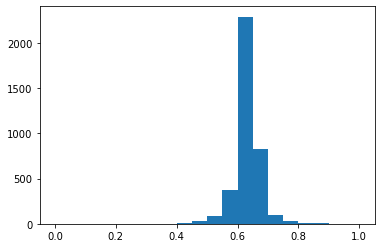

In [6]:
plt.hist(norm_data["Open%PriorClose"], bins=20)

(array([1362.,    0.,    0.,    0.,    0., 1138.,    0.,    0.,    0.,
        1271.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

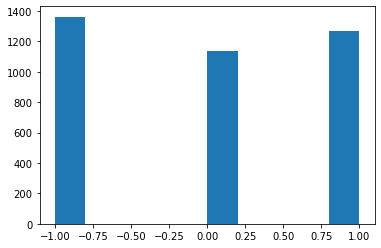

In [7]:
plt.hist(labels)

(array([  1.,   0.,   1.,   0.,   4.,   0.,   1.,   1.,   1.,   2.,   4.,
          6.,   8.,  12.,  18.,  23.,  59.,  70., 151., 220., 384., 694.,
        866., 649., 295., 139.,  77.,  30.,  18.,  18.,   3.,   3.,   1.,
          2.,   6.,   2.,   0.,   0.,   1.,   1.]),
 array([-8.21363697, -7.841296  , -7.46895504, -7.09661407, -6.7242731 ,
        -6.35193214, -5.97959117, -5.6072502 , -5.23490924, -4.86256827,
        -4.4902273 , -4.11788634, -3.74554537, -3.3732044 , -3.00086344,
        -2.62852247, -2.2561815 , -1.88384054, -1.51149957, -1.1391586 ,
        -0.76681764, -0.39447667, -0.0221357 ,  0.35020526,  0.72254623,
         1.0948872 ,  1.46722816,  1.83956913,  2.2119101 ,  2.58425106,
         2.95659203,  3.328933  ,  3.70127396,  4.07361493,  4.4459559 ,
         4.81829686,  5.19063783,  5.5629788 ,  5.93531976,  6.30766073,
         6.6800017 ]),
 <BarContainer object of 40 artists>)

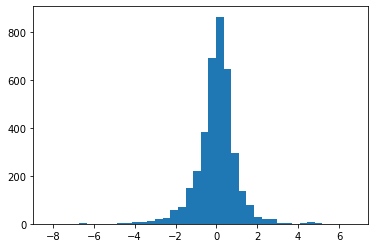

In [8]:
norm_N5D=(N5D-N5D.mean())/N5D.std()
plt.hist(norm_N5D, bins=40)

In [9]:
# Splitting training data to train and test data
train_data, test_data, train_labels, test_labels = train_test_split(
    norm_data, labels, test_size=0.2, shuffle=False)

## Take a look at the data sets
print("train_data:", train_data.shape)
print("train_labels:", train_labels.shape)
print("test_data:", test_data.shape)
print("test_labels:", test_labels.shape)

train_data: (3016, 47)
train_labels: (3016,)
test_data: (755, 47)
test_labels: (755,)


(array([258.,   0.,   0.,   0.,   0., 215.,   0.,   0.,   0., 282.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

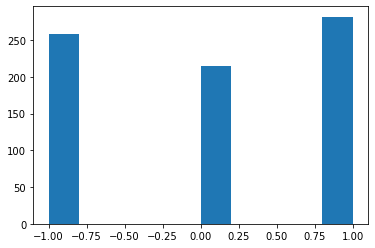

In [10]:
plt.hist(test_labels)

## Logistic Regression Model

In [11]:
## Logistic Regression model, feature select using L2 regularization
print("Logistic Regression Model:\n")
print("{:>8}  {:>10}{:>10}".format("L2 c", "accuracy", "f1"))
print("-" * 30)

# Produce Logistic Regression models with various C values
c_values = [0.01, 0.1, 1, 10, 100, 500, 1000, 2500, 5000, 7000, 8000, 9000, 10000, 20000]
best_c, best_f1 = 0, 0

for c in c_values:
    lr_model = LogisticRegression(C=c, solver="liblinear")
    lr_model.fit(train_data, train_labels)
    accuracy = lr_model.score(test_data, test_labels)
    f1 = metrics.f1_score(test_labels, lr_model.predict(test_data), average='weighted')
    print("{:>8}  {:10.4f}{:10.4f}".format(c, accuracy, f1))
    if f1 > best_f1:
        best_c = c
        best_f1 = f1 

print("\nBest f1 score of {:.4f} at C={}".format(best_f1, best_c))
c_l2 = best_c

Logistic Regression Model:

    L2 c    accuracy        f1
------------------------------
    0.01      0.3762    0.3562
     0.1      0.3934    0.3904
       1      0.4252    0.4233
      10      0.4212    0.4195
     100      0.4212    0.4192
     500      0.4212    0.4195
    1000      0.4225    0.4209
    2500      0.4225    0.4220
    5000      0.4185    0.4181
    7000      0.4185    0.4183
    8000      0.4185    0.4182
    9000      0.4159    0.4157
   10000      0.4159    0.4156
   20000      0.4106    0.4104

Best f1 score of 0.4233 at C=1


In [12]:
# Get the best model results
lr_model = LogisticRegression(C=c_l2, solver="liblinear")
lr_model.fit(train_data, train_labels)

LogisticRegression(C=1, solver='liblinear')

### Take a look at the classification report

In [13]:
# First look at classification report
pred_labels = lr_model.predict(test_data)
score=lr_model.score(test_data, test_labels)
target_names = ['Sell', 'Hold', 'Buy']

print(classification_report(test_labels, pred_labels, target_names = target_names) )

              precision    recall  f1-score   support

        Sell       0.38      0.38      0.38       258
        Hold       0.42      0.54      0.47       215
         Buy       0.48      0.38      0.43       282

    accuracy                           0.43       755
   macro avg       0.43      0.43      0.43       755
weighted avg       0.43      0.43      0.42       755



(array([256.,   0.,   0.,   0.,   0., 276.,   0.,   0.,   0., 223.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

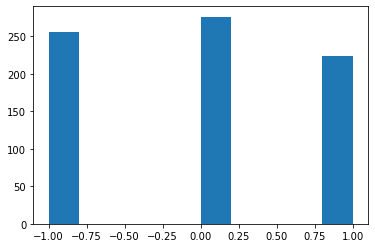

In [14]:
plt.hist(pred_labels)

In [15]:
print(confusion_matrix(test_labels, pred_labels))

[[ 97  85  76]
 [ 60 116  39]
 [ 99  75 108]]


### Examine feature coefficients of best model with L2 regularization

In [16]:
## Get the top features from the model
indices, features, sell_weights, hold_weights, buy_weights = [], [], [], [], []
indices.extend(np.argsort(-lr_model.coef_[2]))

for i in indices:
    features.append(train_data.columns[i])
    sell_weights.append(lr_model.coef_[0][i])
    hold_weights.append(lr_model.coef_[1][i])
    buy_weights.append(lr_model.coef_[2][i])
    
## Set up table to print results
print("Features from the Logistic Regression Model with Weights:\n")
print("{:>20}{:>20}{:>20}{:>20}".format("Features", "Sell Weight", "Hold Weight", "Buy Weight"))
print("-" * 80)

## Print the features along with weights
for i in range(int(len(features))):
        print("{:>20}{:20.4f}{:20.4f}{:20.4f}"
              .format(features[i], sell_weights[i], hold_weights[i], buy_weights[i]))

Features from the Logistic Regression Model with Weights:

            Features         Sell Weight         Hold Weight          Buy Weight
--------------------------------------------------------------------------------
              SMA30%             -0.3312             -0.5591              0.9556
              Fast_D             -0.5848             -0.3466              0.7710
           %52Wk_Low             -0.0131             -0.6789              0.6450
              SMA15%             -0.2795             -0.1558              0.4613
              SMA20%             -0.1415             -0.1660              0.3922
              EMA20%             -0.0054             -0.3235              0.3770
          RSI_Signal             -0.1737             -0.1770              0.3715
              SMA10%             -0.0077             -0.3044              0.3115
              EMA30%              0.1583             -0.4351              0.3107
              EMA15%             -0.0239          

### Additional feature selection using both L1 and L2 regularization

In [17]:
## Improved Logistic Regression Model: using preprocessed training and dev data
np.random.seed(0) ## keep for comparison purposes

## Print result table headers
print("Logistic Regression Model with L1 and L2 Regularization:\n")
print("{:>15}{:>15}{:>15}{:>15}".format("L1 C value", "feature size", "accuracy", "f1"))
print("-" * 60)

## Produce Logistic Regression models with various C values for L1 regularization
c_values = c_values = [0.01, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500]
best_c, best_f1 = 0, 0

for c in c_values:
    ## Feature selection model with L1 regularization, test different C strengths
    lrm = LogisticRegression(C=c, solver="liblinear", penalty="l1", tol=0.015)
    lrm.fit(train_data, train_labels)

    ## Get non-zero features
    nz_features = []
    for i in range(len(features)):
        if abs(lrm.coef_[0][i]) > 0 or abs(lrm.coef_[2][i]) > 0:
            nz_features.append(features[i])
    
    ## New model with L2 regularization
    new_train_data = train_data[nz_features]
    new_test_data = test_data[nz_features]

    lrm = LogisticRegression(C=10, solver="liblinear", penalty="l2")
    lrm.fit(new_train_data, train_labels)
    accuracy = lrm.score(new_test_data, test_labels)
    f1 = metrics.f1_score(test_labels, lrm.predict(new_test_data), average='weighted')
    print("{:>15}{:>15}{:>15.4f}{:>15.4f}".format(c, len(nz_features), accuracy, f1))
    if f1 > best_f1:
        best_c = c
        best_f1 = f1

print("\nBest f1 score of {:.4f} at L1 C={}".format(best_f1, best_c))
c_l1 = best_c

Logistic Regression Model with L1 and L2 Regularization:

     L1 C value   feature size       accuracy             f1
------------------------------------------------------------
           0.01              5         0.3828         0.3723
            0.1             12         0.4146         0.4041
            0.2             23         0.4119         0.4031
            0.5             34         0.4265         0.4248
              1             45         0.4291         0.4281
              2             43         0.4305         0.4295
              5             45         0.4291         0.4281
             10             46         0.4305         0.4295
             20             46         0.4305         0.4295
             50             46         0.4305         0.4295
            100             46         0.4305         0.4295
            200             46         0.4305         0.4295
            500             46         0.4305         0.4295

Best f1 score of 0.4295 at

In [18]:
# Select model result, start with L1 regularization
lrm = LogisticRegression(C=c_l1, solver="liblinear", penalty="l1", tol=0.015)
lrm.fit(train_data, train_labels)

## Get non-zero features
nz_features = []
for i in range(len(train_data.columns)):
    if abs(lrm.coef_[0][i]) > 0 and abs(lrm.coef_[2][i]) > 0:
        nz_features.append(train_data.columns[i])
    
## New model with L2 regularization
new_train_data = train_data[nz_features]
new_test_data = test_data[nz_features]

lrm = LogisticRegression(C=c_l2, solver="liblinear", penalty="l2")
lrm.fit(new_train_data, train_labels)
accuracy = lrm.score(new_test_data, test_labels)
f1 = metrics.f1_score(test_labels, lrm.predict(new_test_data), average='weighted')
lr_model = lrm

## Get the top features from the model
indices, features, sell_weights, hold_weights, buy_weights = [], [], [], [], []
indices.extend(np.argsort(-lr_model.coef_[2]))

for i in indices:
    features.append(new_train_data.columns[i])
    sell_weights.append(lr_model.coef_[0][i])
    hold_weights.append(lr_model.coef_[1][i])
    buy_weights.append(lr_model.coef_[2][i])
    
## Set up table to print results
print("Features from the Logistic Regression Model with Weights:\n")
print("{:>20}{:>20}{:>20}{:>20}".format("Features", "Sell Weight", "Hold Weight", "Buy Weight"))
print("-" * 80)

## Print the features along with weights
for i in range(int(len(features))):
        print("{:>20}{:20.4f}{:20.4f}{:20.4f}"
              .format(features[i], sell_weights[i], hold_weights[i], buy_weights[i]))

Features from the Logistic Regression Model with Weights:

            Features         Sell Weight         Hold Weight          Buy Weight
--------------------------------------------------------------------------------
              SMA30%             -0.3281             -0.5687              0.9523
              Fast_D             -0.5615             -0.4520              0.7694
           %52Wk_Low             -0.0121             -0.6827              0.6464
              SMA15%             -0.2765             -0.1936              0.4599
              SMA20%             -0.1510             -0.1866              0.3919
              EMA20%             -0.0127             -0.3335              0.3764
          RSI_Signal             -0.1613             -0.1982              0.3713
              EMA30%              0.1447             -0.4250              0.3109
              SMA10%             -0.0052             -0.3273              0.3107
              EMA15%             -0.0301          

In [19]:
# Look at classification report
pred_labels = lr_model.predict(new_test_data)
score=lr_model.score(new_test_data, test_labels)
target_names = ['Sell', 'Hold', 'Buy']

print(classification_report(test_labels, pred_labels, target_names = target_names) )

              precision    recall  f1-score   support

        Sell       0.37      0.37      0.37       258
        Hold       0.42      0.53      0.47       215
         Buy       0.48      0.38      0.42       282

    accuracy                           0.42       755
   macro avg       0.42      0.43      0.42       755
weighted avg       0.43      0.42      0.42       755



(array([258.,   0.,   0.,   0.,   0., 275.,   0.,   0.,   0., 222.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

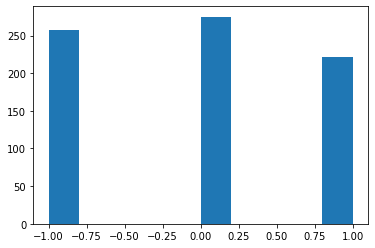

In [20]:
plt.hist(pred_labels)

In [21]:
print(confusion_matrix(test_labels, pred_labels))

[[ 96  86  76]
 [ 61 115  39]
 [101  74 107]]
